**Tarrasque: Redes Neurais Multicamadas para Modelagem Preditiva da Resposta Dielétrica de Perovskitas**
==========================================================

**Autores:**
* Ana Luz P. Mendes - 24007
* Caio M. Leão Dantas - 24034
* Rafael Anis S. Santos - 24018

**Orientação:**
* Prof. Dr. Daniel R. Cassar

---

## **CONTRIBUIÇÃO DOS AUTORES**

A discussão acerca do tema e o código foram realizados em conjunto pelos três autores.

---

## **Introdução**

Neste trabalho, exploramos o uso de redes neurais do tipo MLP (Multilayer Perceptron) para prever a constante dielétrica de diferentes materiais com estrutura de perovskita, utilizando dados obtidos de um artigo científico.

As perovskitas formam uma família de materiais com estrutura cristalina do tipo ABX₃, que permite uma ampla diversidade de composições químicas. Por causa dessa versatilidade, elas têm sido amplamente estudadas em aplicações como células solares, sensores, dispositivos de memória e componentes eletrônicos avançados. Entre as propriedades mais importantes nesse contexto está a constante dielétrica, que descreve o quanto o material consegue armazenar energia elétrica em um campo. Essa constante afeta diretamente o comportamento de dispositivos como capacitores, transistores e sensores — ou seja, prever esse valor com precisão pode acelerar bastante o desenvolvimento de novos materiais funcionais.

<p align="center">
<img src="https://www.solarchoice.net.au/wp-content/uploads/Perovskite-crystal.png" width="471" height="364" />
</p>
<p align="center">
Figura 1: Esquema representando a estrutura geral de perovskitas.
</p>

Por outro lado, obter a constante dielétrica por métodos teóricos ou experimentais pode ser demorado e custoso, principalmente quando lidamos com grandes conjuntos de materiais. E é exatamente aí que entra o aprendizado de máquina: ao treinar uma rede neural com exemplos conhecidos, podemos construir um modelo capaz de prever esse valor a partir de propriedades estruturais e eletrônicas do material.

A proposta do projeto é testar e otimizar os hiperparâmetros de uma rede MLP para resolver esse problema de regressão. Para isso, geramos e avaliamos mais de 100 arquiteturas diferentes, variando funções de ativação, número de neurônios por camada e taxas de aprendizado. O desempenho de cada rede é analisado com base no erro de predição sobre os dados de constante dielétrica.

Este notebook apresenta as etapas desse processo: desde o carregamento e pré-processamento dos dados, até o treinamento das redes e análise dos resultados.

## **Importando as bibliotecas**

Bibliotecas próprias do Python:

In [2]:
import os
import re
import random
import copy
from itertools import product
from pprint import pprint

Bibliotecas adjuntas necessárias para o desenvolvimento do código, presentes no *requirements* do Gitub:

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pymatgen.io.cif import CifParser
from pymatgen.core.composition import Composition
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## **Encontrando e extraindo os arquivos CIF**

Precisamos olhar o diretório que estamos buscando:

In [4]:
os.getcwd()

'/home/caio24034/Tarrasque'

E então adaptar para encontrar a pasta com todos arquivos *.cif*:

In [5]:
cif_dir = '/home//caio24034//Tarrasque//cif_merge'
files = [f for f in os.listdir(cif_dir)]

Código para extrair metadados dos nossos arquivos:

###### O código possui como base o ChatGPT. A conversa pode ser analisada na Referência 1.

In [6]:
def parse_metadata(lines):
    meta = {}  # dicionário que vai guardar os metadados

    # compila uma expressão regular para capturar "texto antes dos dois-pontos" e "texto depois dos dois-pontos"
    pat = re.compile(r"#\s*(.+?):\s*(.+)")

    for l in lines:
        m = pat.match(l)      # tenta encaixar cada linha no padrão
        if m:
            # grupo 1 é tudo antes dos dois-pontos: vira a chave
            key = m.group(1).strip().lower().replace(" ", "_")
            # grupo 2 é tudo depois dos dois-pontos: vira o valor
            val = m.group(2).strip()
            # tenta converter em float; se falhar, mantém como string
            try:
                val = float(val)
            except:
                pass
            meta[key] = val      # adiciona ao dicionário
    return meta

Extraímos dados de todos arquivos e adicionamos em records.


In [7]:
records = []
for fname in files:
    path = os.path.join(cif_dir, fname)
    # 3.1) ler a parte de comentários
    with open(path, "r") as f:
        lines = f.readlines()
    metadata = parse_metadata(lines)
    # 3.2) usar pymatgen para pegar estrutura
    parser = CifParser(path)
    struct = parser.get_structures(primitive=False)[0]
    # extrair parâmetros de grade
    a, b, c = struct.lattice.abc
    alpha, beta, gamma = struct.lattice.angles
    # extrair composição
    comp = Composition(struct.composition).as_dict()  # ex: {'C':3,'H':10,...}
    # síntese de features
    record = {

        "a": a, "b": b, "c": c,
        "alpha": alpha, "beta": beta, "gamma": gamma,
        # comp.jar: opção simples: frações atômicas
        **{f"frac_{el}": comp.get(el,0)/sum(comp.values()) for el in comp},

         "dielectric_constant_total": metadata.get("dielectric_constant,_total"),
    }
    records.append(record)


/tmp/ipykernel_1423637/424077781.py:10: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  struct = parser.get_structures(primitive=False)[0]
/home/caio24034/anaconda3/lib/python3.11/site-packages/pymatgen/io/cif.py:1028: UserWarning: No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
  self.symmetry_operations = self.get_symops(data)  # type:ignore[assignment]
/home/caio24034/anaconda3/lib/python3.11/site-packages/pymatgen/io/cif.py:1348: UserWarning: Issues encountered while parsing CIF: No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
  return self.parse_structures(*args, **kwargs)
/home/caio24034/anaconda3/lib/python3.11/site-packages/pymatgen/io/cif.py:1348: Use

## **Tratamento de Dados**

Transformamos nossos dados extraídos em `DataFrame`:

In [8]:
df = pd.DataFrame(records)
df

,a,b,c,alpha,beta,gamma,frac_H,frac_Pb,frac_C,frac_Br,frac_N,dielectric_constant_total,frac_Sn,frac_O,frac_Ge,frac_F,frac_I,frac_Cl
0,5.996031,4.337943,9.192422,117.952746,84.011623,93.800081,0.500000,0.083333,0.083333,0.250000,0.083333,12.6335,NaN,NaN,NaN,NaN,NaN,NaN
1,7.453813,4.441428,5.980436,91.816292,95.063140,72.207397,0.400000,NaN,NaN,0.300000,0.100000,19.9087,0.100000,0.1,NaN,NaN,NaN,NaN
2,5.598298,5.142794,4.689996,76.641731,82.635398,97.691254,0.357143,NaN,0.214286,NaN,0.142857,4.7687,NaN,NaN,0.071429,0.214286,NaN,NaN
3,6.800557,6.516125,6.590241,81.084559,83.046829,89.577559,0.555556,NaN,0.166667,NaN,0.055556,7.0145,NaN,NaN,0.055556,NaN,0.166667,NaN
4,6.640031,4.993198,9.132611,92.512048,83.593587,81.789241,0.555556,NaN,0.166667,NaN,0.055556,13.4742,0.055556,NaN,NaN,NaN,0.166667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,8.504711,5.887711,6.020915,108.015623,46.532882,116.233543,0.454545,0.090909,NaN,0.272727,0.181818,17.7084,NaN,NaN,NaN,NaN,NaN,NaN
1342,11.414296,4.403238,6.233692,94.861134,58.900767,108.793978,0.555556,0.055556,0.166667,0.166667,0.055556,9.9000,NaN,NaN,NaN,NaN,NaN,NaN
1343,8.261001,4.740254,7.262191,110.061214,79.198441,105.034811,0.555556,NaN,0.166667,0.166667,0.055556,10.3666,0.055556,NaN,NaN,NaN,NaN,NaN
1344,6.492051,6.520983,6.453254,82.140322,100.256437,98.646731,0.533333,NaN,0.133333,NaN,0.066667,7.4200,NaN,NaN,0.066667,NaN,0.200000,NaN


In [9]:
df.fillna(0, inplace=True)  # substitui NaN por 0
df

,a,b,c,alpha,beta,gamma,frac_H,frac_Pb,frac_C,frac_Br,frac_N,dielectric_constant_total,frac_Sn,frac_O,frac_Ge,frac_F,frac_I,frac_Cl
0,5.996031,4.337943,9.192422,117.952746,84.011623,93.800081,0.500000,0.083333,0.083333,0.250000,0.083333,12.6335,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,7.453813,4.441428,5.980436,91.816292,95.063140,72.207397,0.400000,0.000000,0.000000,0.300000,0.100000,19.9087,0.100000,0.1,0.000000,0.000000,0.000000,0.0
2,5.598298,5.142794,4.689996,76.641731,82.635398,97.691254,0.357143,0.000000,0.214286,0.000000,0.142857,4.7687,0.000000,0.0,0.071429,0.214286,0.000000,0.0
3,6.800557,6.516125,6.590241,81.084559,83.046829,89.577559,0.555556,0.000000,0.166667,0.000000,0.055556,7.0145,0.000000,0.0,0.055556,0.000000,0.166667,0.0
4,6.640031,4.993198,9.132611,92.512048,83.593587,81.789241,0.555556,0.000000,0.166667,0.000000,0.055556,13.4742,0.055556,0.0,0.000000,0.000000,0.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,8.504711,5.887711,6.020915,108.015623,46.532882,116.233543,0.454545,0.090909,0.000000,0.272727,0.181818,17.7084,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1342,11.414296,4.403238,6.233692,94.861134,58.900767,108.793978,0.555556,0.055556,0.166667,0.166667,0.055556,9.9000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1343,8.261001,4.740254,7.262191,110.061214,79.198441,105.034811,0.555556,0.000000,0.166667,0.166667,0.055556,10.3666,0.055556,0.0,0.000000,0.000000,0.000000,0.0
1344,6.492051,6.520983,6.453254,82.140322,100.256437,98.646731,0.533333,0.000000,0.133333,0.000000,0.066667,7.4200,0.000000,0.0,0.066667,0.000000,0.200000,0.0


Escolhemos, aqui, nossos atributos e target para a previsão.

Os `atributos` contém: 
- Comprimentos dos vetores da célula unitária;
- Ângulos alfa, beta e gama da estrutura do material;
- Frações atômicas de cada elemento químico. 

Enquanto o `target` se trata da constante dielétrica total.

In [10]:
x = df.drop(columns=["dielectric_constant_total"]).values
y = df["dielectric_constant_total"].values

Definimos aqui as constantes que iremos utilizar no processo de divisão dos dados entre treino, teste e validação:

In [11]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1
TAMANHO_TREINO = 1 - TAMANHO_TESTE - TAMANHO_VALIDACAO
TAMANHO_TREINO, TAMANHO_VALIDACAO, TAMANHO_TESTE
SEMENTE_ALEATORIA = 8

Dividimos primeiramente em dois grupos, de modo a "agrupar" os dados de treino e validação para uma posterior divisão:

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

E aqui realizamos a segunda divisão, obtendo os três grupos de dados divididos:

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=TAMANHO_VALIDACAO, random_state=SEMENTE_ALEATORIA)

Transformamos todos esses dados que nós possuímos em `tensores`. Essa etapa é realizada em virtude da biblioteca PyTorch necessitar que os dados estejam nessa configuração para que funcione de maneira adequada:

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
X_val  = torch.tensor(X_val,  dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)
y_val  = torch.tensor(y_val,  dtype=torch.float32)

## **Como funciona a rede neural para 1 única arquitetura**

Definimos um número sorteado de neurônios presentes em cada camada da rede:

In [15]:
C1 = random.randint(1, 5)
C2 = random.randint(1, 5)
print("Número de neurônios na camada 1:", C1)
print("Número de neurônios na camada 2:", C2)

Número de neurônios na camada 1: 1
Número de neurônios na camada 2: 4


Definimos também uma lista de funções de ativação possíveis de utilizar na rede:

In [16]:
lista_funcoes_ativacao = [nn.ReLU(), nn.LeakyReLU(negative_slope=0.01), nn.ELU(alpha=1.0), nn.GELU(), nn.SiLU()]

E definimos enfim as constantes para utilizar na rede neural:

In [17]:
N_DADOS_DE_ENTRADA = len(x[0])
N_CAMADAS = 5
N_DADOS_DE_SAIDA = 1

Para que a rede neural funcione de forma efetiva, definimos uma classe associada à rede:

In [18]:
class MLP(nn.Module):
    def __init__(self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets, lista_funcoes_ativacao):
        super().__init__()
        função1 = random.choice(lista_funcoes_ativacao)
        função2 = random.choice(lista_funcoes_ativacao)
        print("1ª Função de Ativação Sorteada:", função1)
        print("2ª Função de Ativação Sorteada:", função2)
        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            função1,
            nn.Linear(neuronios_c1, neuronios_c2),
            função2,
            nn.Linear(neuronios_c2, num_targets),
        )
        
    def forward(self, x):
        x = self.camadas(x)
        return x

E utilizamos as funções de ativação sorteadas com a quantidade de neurônios por camada também sorteados para instanciar a rede:

In [19]:
minha_mlp = MLP(
    N_DADOS_DE_ENTRADA, C1, C2, N_DADOS_DE_SAIDA, lista_funcoes_ativacao

)

1ª Função de Ativação Sorteada: ELU(alpha=1.0)
2ª Função de Ativação Sorteada: GELU(approximate='none')


Podemos, claro, analisar os parâmetros da nossa rede e associá-los aos seus significados:

In [20]:
for name, param in minha_mlp.named_parameters():
    print(f"{name}: {param.shape}")

camadas.0.weight: torch.Size([1, 17])
camadas.0.bias: torch.Size([1])
camadas.2.weight: torch.Size([4, 1])
camadas.2.bias: torch.Size([4])
camadas.4.weight: torch.Size([1, 4])
camadas.4.bias: torch.Size([1])


Definimos um otimizador e uma função de perda para análise do modelo, além de uma taxa de aprendizado:

In [21]:
TAXA_DE_APRENDIZADO = 0.01

otimizador = optim.SGD(minha_mlp.parameters(), lr=TAXA_DE_APRENDIZADO)
fn_perda = nn.MSELoss()
perdas_treino = []

Analisamos o desempenho do treinamento modelo durante as épocas:

In [22]:
NUM_EPOCAS = 100

minha_mlp.train()

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_prev = minha_mlp(X_train)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_train, y_prev)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # armazena perda
    perdas_treino.append(loss.item())

    # mostra resultado (opcional)
    print(epoca, loss.data)

0 tensor(283.0988)
1 tensor(229.9369)
2 tensor(222.7667)
3 tensor(215.5238)
4 tensor(207.9070)
5 tensor(199.3697)
6 tensor(188.9885)
7 tensor(175.4992)
8 tensor(157.9672)
9 tensor(137.1741)
10 tensor(116.2766)
11 tensor(99.4309)
12 tensor(89.1410)
13 tensor(84.5861)
14 tensor(83.1189)
15 tensor(82.7525)
16 tensor(82.6748)
17 tensor(82.6597)
18 tensor(82.6569)
19 tensor(82.6564)
20 tensor(82.6563)
21 tensor(82.6563)
22 tensor(82.6563)
23 tensor(82.6563)
24 tensor(82.6563)
25 tensor(82.6563)
26 tensor(82.6563)
27 tensor(82.6563)
28 tensor(82.6563)
29 tensor(82.6563)
30 tensor(82.6563)
31 tensor(82.6563)
32 tensor(82.6563)
33 tensor(82.6563)
34 tensor(82.6563)
35 tensor(82.6563)
36 tensor(82.6563)
37 tensor(82.6563)
38 tensor(82.6563)
39 tensor(82.6563)
40 tensor(82.6563)
41 tensor(82.6563)
42 tensor(82.6563)
43 tensor(82.6563)
44 tensor(82.6563)
45 tensor(82.6563)
46 tensor(82.6563)
47 tensor(82.6563)
48 tensor(82.6563)
49 tensor(82.6563)
50 tensor(82.6563)
51 tensor(82.6563)
52 tensor(8

/home/caio24034/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1089, 1])) that is different to the input size (torch.Size([1089])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E plotamos uma curva de aprendizado para que seja possível uma melhor análise do treinamento em si:

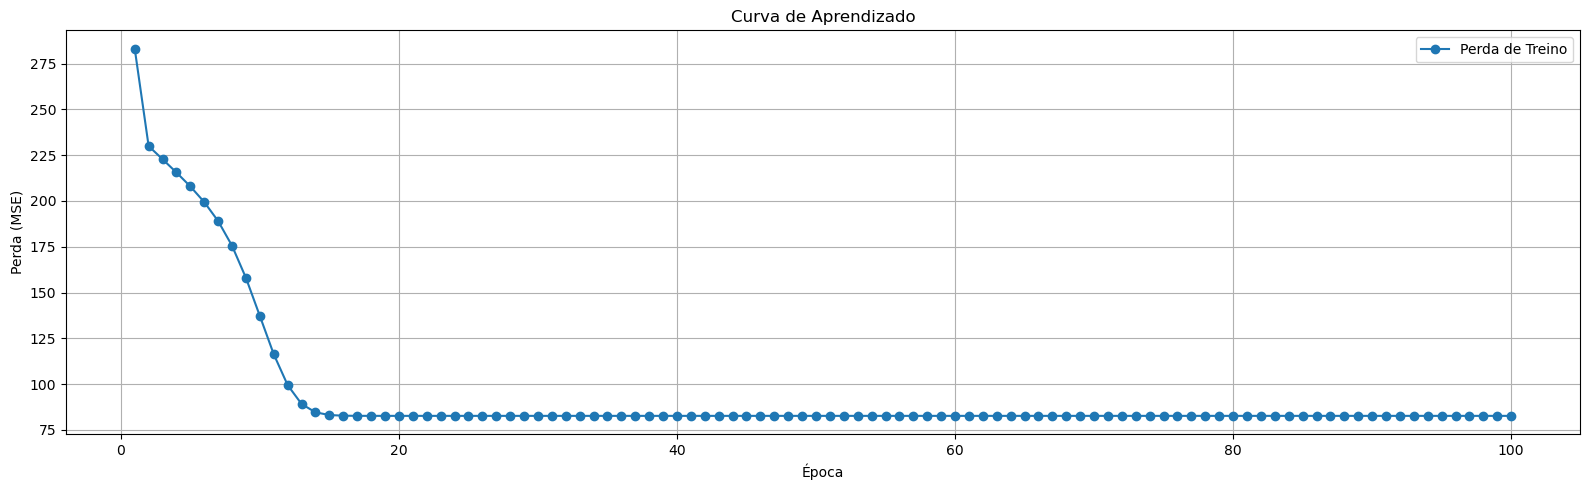

In [23]:
plt.figure(figsize=(16, 5))
plt.plot(range(1, NUM_EPOCAS+1), perdas_treino, marker='o')
plt.xlabel("Época")
plt.ylabel("Perda (MSE)")
plt.title("Curva de Aprendizado")
plt.grid(True)
plt.tight_layout()
plt.legend(["Perda de Treino"])
plt.show()

## **Implementando para mais arquiteturas**

Aqui, definimos nossos hiperparâmetros que serão otimizados na busca de uma arquitetura mais favorável da rede:

In [24]:
LISTA_FUNCOES_ATIVACAO = [nn.GELU() , nn.ReLU(), nn.LeakyReLU(negative_slope=0.01), nn.SiLU()]
LISTA_QNT_NEURONIOS = [3, 4, 5]
LISTA_TAXA_APRENDIZADO = [0.01, 0.001, 0.0001]

Para otimizarmos nossa rede, utilizaremos uma espécie de `busca em grade` que combinará todas as possíveis opções de arquitetura dentro das que definimos ser possíveis e fará uma comparação. Para isso, utilizaremos da biblioteca *`itertools`* e geraremos uma lista das possíveis arquiteturas:

In [25]:
combinacoes = list(product(LISTA_FUNCOES_ATIVACAO, LISTA_FUNCOES_ATIVACAO, LISTA_QNT_NEURONIOS, LISTA_QNT_NEURONIOS, LISTA_TAXA_APRENDIZADO))

pprint(combinacoes)

[(GELU(approximate='none'), GELU(approximate='none'), 3, 3, 0.01),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 3, 0.001),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 3, 0.0001),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 4, 0.01),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 4, 0.001),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 4, 0.0001),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 5, 0.01),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 5, 0.001),
 (GELU(approximate='none'), GELU(approximate='none'), 3, 5, 0.0001),
 (GELU(approximate='none'), GELU(approximate='none'), 4, 3, 0.01),
 (GELU(approximate='none'), GELU(approximate='none'), 4, 3, 0.001),
 (GELU(approximate='none'), GELU(approximate='none'), 4, 3, 0.0001),
 (GELU(approximate='none'), GELU(approximate='none'), 4, 4, 0.01),
 (GELU(approximate='none'), GELU(approximate='none'), 4, 4, 0.001),
 (GELU(approximate='none'), GELU(approximate='non

Definimos uma classe para a rede neural baseado nas diferentes arquiteturas:

In [26]:
class MLP_ARQUITETURAS(nn.Module):
    def __init__(self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets, funcao_1, funcao_2):
        super().__init__()
        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            funcao_1,
            nn.Linear(neuronios_c1, neuronios_c2),
            funcao_2,
            nn.Linear(neuronios_c2, num_targets),
        )
        
    def forward(self, x):
        x = self.camadas(x)
        return x

E realizamos um treinamento por épocas em cada uma das arquiteturas para entender, a partir dos mínimos encontrados por época, qual a melhor configuração estrutural da rede. Além disso, foi implementado uma estratégia de Early Stopping, no intuito de amenizar o custo do modelo e evitar overfitting: 

In [27]:
NUM_EPOCAS = 10000
PACIENCIA = 30

hall_da_fama_treino = []
hall_da_fama_validacao = []


for poss in combinacoes:
    funcao1, funcao2, neuronios_c1, neuronios_c2, taxa_aprendizado = poss

    minha_mlp = MLP_ARQUITETURAS(
        N_DADOS_DE_ENTRADA, neuronios_c1, neuronios_c2, N_DADOS_DE_SAIDA, funcao1, funcao2
    )

    otimizador = optim.SGD(minha_mlp.parameters(), lr=taxa_aprendizado)

    fn_perda = nn.MSELoss()
    melhor_val_loss = float('inf')
    contador_paciencia = 0
    melhores_pesos = None
    melhor_individuo = float("inf")

    minha_mlp.train()

    for epoca in range(NUM_EPOCAS):

        ### TREINO
        y_prev = minha_mlp(X_train)
        otimizador.zero_grad()
        loss_treino= fn_perda(y_train, y_prev)
        loss_treino.backward()
        otimizador.step()

        if loss_treino.data.item() < melhor_individuo:
            melhor_individuo = loss_treino.data.item()

        ### VALIDAÇÃO
        minha_mlp.eval()
        with torch.no_grad():
            y_val_pred = minha_mlp(X_val)
            loss_val = fn_perda(y_val, y_val_pred)

        # print(epoca, "- Perda do treino: ", loss_treino.item(), "/ Perda da validação: ", loss_val.item())


        #Early Stopping
        if loss_val.item() < melhor_val_loss - 1e-3:
            melhor_val_loss = loss_val.item()
            contador_paciencia = 0
            melhores_pesos = copy.deepcopy(minha_mlp.state_dict())
        else:
            contador_paciencia += 1
            if contador_paciencia >= PACIENCIA:
                # print(f"Pausa na época {epoca} pois val_loss não melhorou por {PACIENCIA} épocas), o melhor valor de perda seria de {melhor_val_loss}, na epoca {epoca-PACIENCIA}")
                break
    
    hall_da_fama_treino.append(melhor_individuo)
    hall_da_fama_validacao.append(melhor_val_loss)

indice = hall_da_fama_treino.index(min(hall_da_fama_treino))
print("Melhor perda:", min(hall_da_fama_treino))
print("Combinação que gerou a melhor perda:", combinacoes[indice])

/home/caio24034/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([122, 1])) that is different to the input size (torch.Size([122])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Melhor perda: 82.6562728881836
Combinação que gerou a melhor perda: (GELU(approximate='none'), GELU(approximate='none'), 5, 4, 0.01)


Plotamos o melhor valor encontrado de perda associado a cada arquitetura e analisamos a distribuição delas graficamente.

Primeiro, plotando considerando a função de perda para o treino:

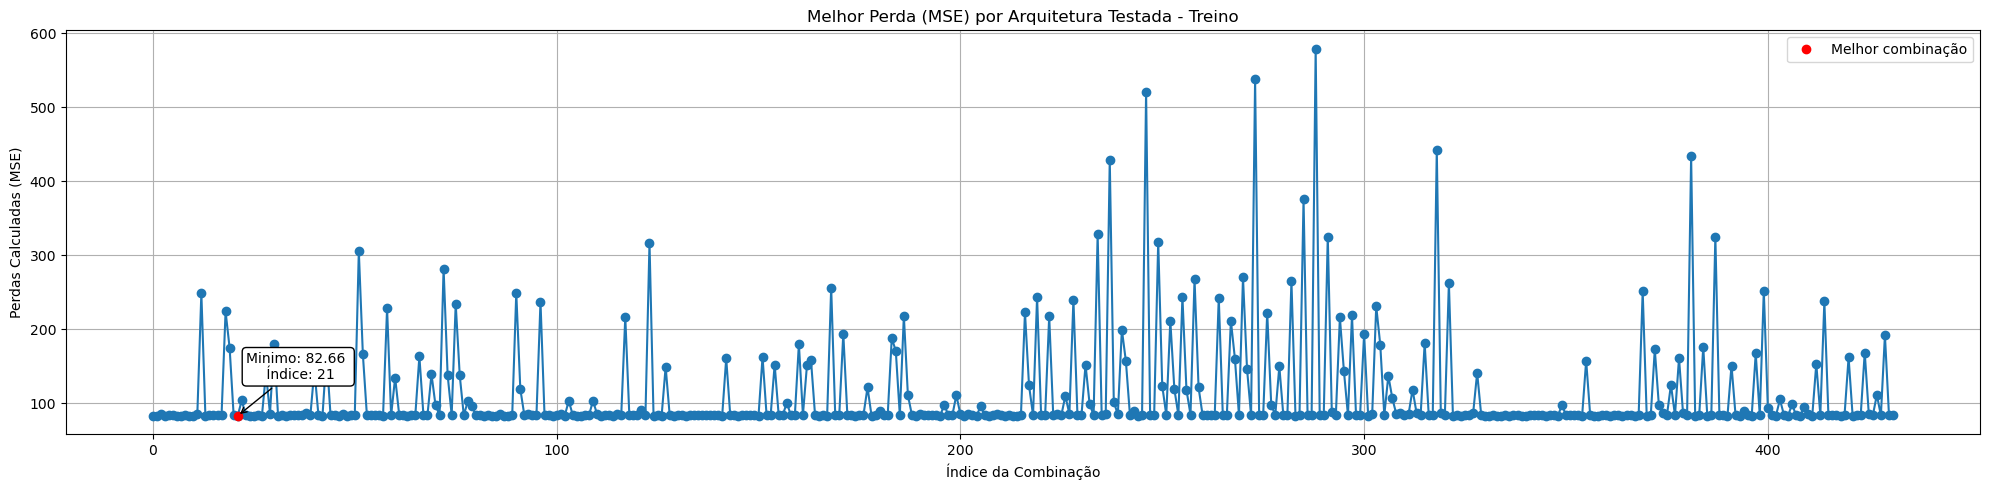

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(hall_da_fama_treino, marker='o')
plt.plot(indice, hall_da_fama_treino[indice], 'ro', label='Melhor combinação')
plt.annotate(f"Minimo: {hall_da_fama_treino[indice]:.2f} \n Índice: {indice}",
             xy=(indice, hall_da_fama_treino[indice]),
             xytext=(indice + 15, hall_da_fama_treino[indice] + 50),
             textcoords='data',
             fontsize=10,
             ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))

plt.title("Melhor Perda (MSE) por Arquitetura Testada - Treino")
plt.xlabel("Índice da Combinação")
plt.ylabel("Perdas Calculadas (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

E depois, plotamos o mesmo gráfico, mas considerando a função de perda para a validação:

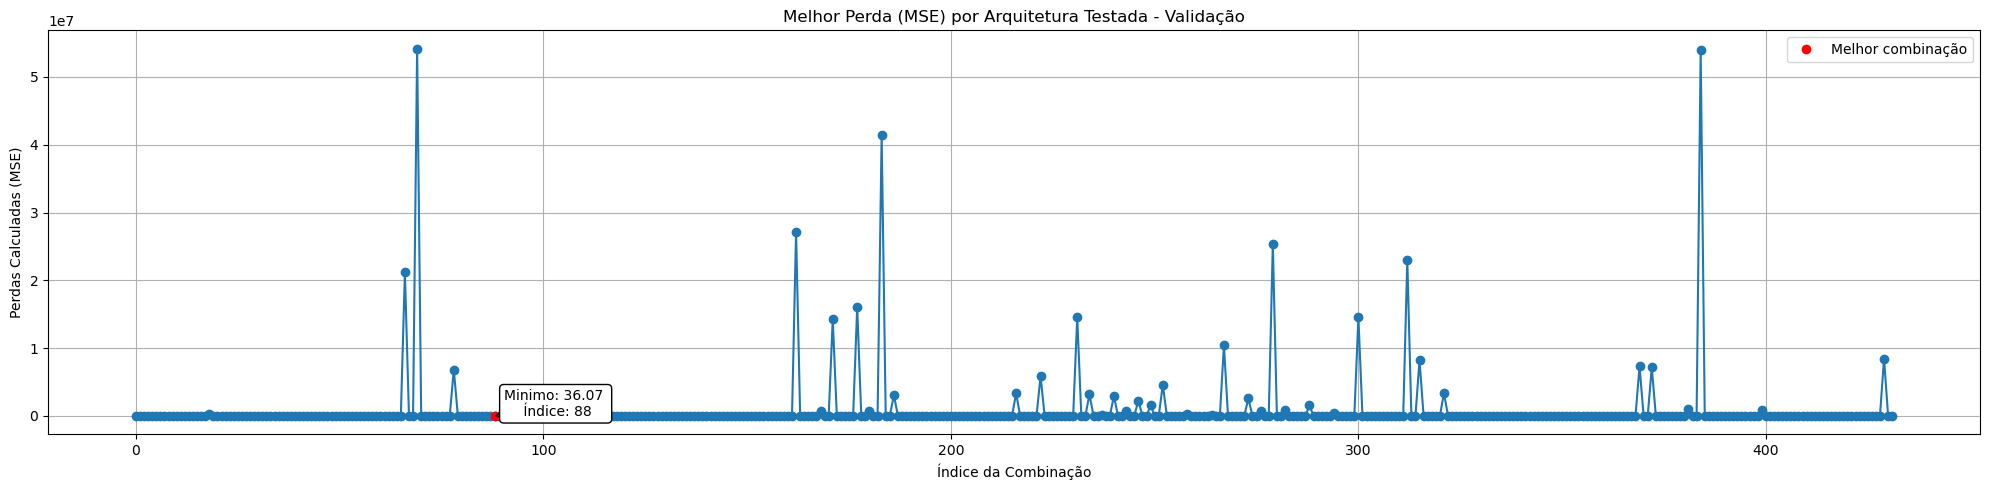

In [38]:
indice_val = hall_da_fama_validacao.index(min(hall_da_fama_validacao))

plt.figure(figsize=(20, 5))
plt.plot(hall_da_fama_validacao, marker='o')
plt.plot(indice_val, hall_da_fama_validacao[indice_val], 'ro', label='Melhor combinação')
plt.annotate(f"Minimo: {hall_da_fama_validacao[indice_val]:.2f} \n Índice: {indice_val}",
             xy=(indice_val, hall_da_fama_validacao[indice_val]),
             xytext=(indice_val + 15, hall_da_fama_validacao[indice_val] + 50),
             textcoords='data',
             fontsize=10,
             ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))

plt.title("Melhor Perda (MSE) por Arquitetura Testada - Validação")
plt.xlabel("Índice da Combinação")
plt.ylabel("Perdas Calculadas (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Agora que sabemos qual a combinação entre as arquiteturas que possui o melhor desempenho, vamos recuperá-la para que seja ela a utilizada no nosso teste definitivo:

In [30]:
melhor_comb = combinacoes[indice]
funcao1, funcao2, neuronios_c1, neuronios_c2, taxa_aprendizado = melhor_comb

melhor_mlp = MLP_ARQUITETURAS(
    N_DADOS_DE_ENTRADA, neuronios_c1, neuronios_c2, N_DADOS_DE_SAIDA, funcao1, funcao2
)

Treinamos a rede novamente com os mesmos dados para garantir que ela esteja treinada (esse processo é realizado aqui porque nós simplesmente recuperamos a rede desenvolvida e com o melhor desempenho, mas não o treinamento que fizemos com ela exatamente):

In [31]:
melhor_mlp.train()
for epoca in range(NUM_EPOCAS):
    y_prev = melhor_mlp(X_train)
    otimizador.zero_grad()
    loss = fn_perda(y_train, y_prev)
    loss.backward()
    otimizador.step()

E aqui realizamos a nossa etapa de teste definitivo após o treinamento, de modo a entender mais um pouco sobre o desempenho do modelo com os dados. Colocamos a nossa MLP em modo de avalição (*eval*) e prevemos os valores de y para essa MLP:

In [32]:
melhor_mlp.eval()

MLP_ARQUITETURAS(
  (camadas): Sequential(
    (0): Linear(in_features=17, out_features=5, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=5, out_features=4, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [33]:
with torch.no_grad():
    y_pred = melhor_mlp(X_test)

In [34]:
y_pred

tensor([[6.1837],
        [5.4584],
        [6.8385],
        [5.4807],
        [5.9091],
        [5.8724],
        [6.1208],
        [6.7718],
        [6.9545],
        [5.6916],
        [6.6384],
        [5.2380],
        [6.3643],
        [6.2224],
        [6.7218],
        [5.4168],
        [6.0569],
        [6.3056],
        [6.0367],
        [6.1266],
        [6.5897],
        [6.3497],
        [6.1927],
        [5.4841],
        [6.3383],
        [7.1592],
        [7.0547],
        [5.6726],
        [5.7252],
        [6.6470],
        [5.9910],
        [5.4231],
        [6.2846],
        [6.5933],
        [6.0444],
        [5.8609],
        [6.8601],
        [5.9862],
        [6.3123],
        [6.6649],
        [5.2164],
        [5.2545],
        [6.3324],
        [5.8193],
        [6.7053],
        [5.7975],
        [5.0764],
        [6.0134],
        [6.5189],
        [6.2812],
        [5.6191],
        [6.0216],
        [6.1475],
        [6.0327],
        [6.2546],
        [5

A partir do teste realizado, selecionamos uma métrica com a qual podemos analisar o desempenho e efetividade do modelo no nosso objetivo de previsão: 

In [35]:
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(RMSE)

15.438433


---

## **Conclusões** 

Com esse notebook buscamos realizar uma predição da constante dielétrica de diferentes perovskitas. Fizemos uma otimização de hiperparâmetros por busca em grade, testando 432 arquiteturas diferentes, variando hiperparâmetros como funções de ativação, número de neurônios por camada e taxa de aprendizado. Visto que mantemos o número de épocas constante, decidimos implementar a estratégia de Early Stopping para evitar overfitting.

Ao fim, após a otimização, avaliamos nosso modelo e se obteve um RMSE de 15,44. Considerando que as constantes dielétricas do nosso dataset também estão na ordem de dezenas, esse RMSE não é considerado ideal. Para melhorar a perfomance da nossa rede poderiamos tentar diversas estratégias como utilizar reguladores e normalizadores.

---

## **Referências**

**[1]** CASSAR, Daniel. Redes Neurais e Algoritmos Genéticos. 2025. Material de Aula.

**[2]** KIM, C. et al. A hybrid organic-inorganic perovskite dataset. Scientific data, v. 4, n. 1, p. 170057. 2017.

**[3]** https://chatgpt.com/share/68361451-bb0c-800b-a360-3d0e9070f929